<a href="https://colab.research.google.com/github/hyulianton/BigData/blob/main/Proyek_Big_Data_Analisis_Sentimen_Ulasan_Film_Bioskop_untuk_Rekomendasi_Konten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Java Development Kit versi 8

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Download spark versi 3.5.6

In [ ]:
!wget https://downloads.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz

Ekstrak spark

In [ ]:
!tar -xf spark-3.5.6-bin-hadoop3.tgz

Setting environment variable

In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.6-bin-hadoop3"

Install library spark

In [2]:
!pip install findspark -q -q -q
!pip install pyspark -q -q -q

# Proyek Big Data: Analisis Sentimen Ulasan Film Bioskop untuk Rekomendasi Konten

Proyek ini bertujuan untuk membangun sebuah sistem analisis sentimen sederhana dari ulasan film. Hasil analisis sentimen ini nantinya dapat digunakan untuk memberikan wawasan kepada produser film atau platform streaming mengenai persepsi publik terhadap film-film tertentu, bahkan bisa menjadi dasar untuk sistem rekomendasi konten yang lebih kompleks di masa depan.

## Mengapa Proyek Ini Penting?

-   **Big Data:** Kita akan menghadapi data teks dalam jumlah besar (ulasan film) yang perlu diproses.
    
-   **Data Pipelines:** Mahasiswa akan belajar bagaimana mengambil data, membersihkannya, dan menyusunnya untuk analisis.
    
-   **Batch Processing:** Kita akan menggunakan teknik _batch processing_ untuk menganalisis sentimen secara periodik.
    
-   **Dampak Nyata:** Hasilnya adalah visualisasi sentimen yang jelas, menunjukkan wawasan yang dapat ditindaklanjuti.
    
-   **Skill Set Big Data Scientist:** Proyek ini melatih kemampuan _end-to-end_ mulai dari data mentah hingga wawasan bisnis.
    

## Arsitektur Proyek

Secara garis besar, arsitektur proyek ini akan melibatkan langkah-langkah berikut:

1.  **Pengambilan Data (Data Ingestion):** Menggunakan dataset ulasan film.
    
2.  **Pembersihan & Pra-pemrosesan Data (Data Cleaning & Pre-processing):** Menghilangkan _noise_ dan mempersiapkan teks untuk analisis.
    
3.  **Analisis Sentimen (Sentiment Analysis):** Menerapkan model untuk mengklasifikasikan sentimen (positif, negatif, netral).
    
4.  **Agregasi & Penyimpanan Hasil (Aggregation & Storage):** Mengumpulkan hasil sentimen dan menyimpannya.
    
5.  **Visualisasi Data (Data Visualization):** Menampilkan hasil analisis dalam bentuk dashboard sederhana.
    

Untuk implementasi ini, kita akan asumsikan Spark sudah terinstal dan kita akan memanfaatkan `pyspark` untuk _batch processing_. Untuk dataset, kita akan simulasikan dengan data teks dari library `scikit-learn`, meskipun dalam skenario nyata, ulasan akan diambil dari API seperti IMDb atau Twitter.

----------

## Implementasi Program Python

Kita akan membagi implementasi menjadi beberapa bagian fungsional.

### Prasyarat

Pastikan Anda telah menginstal library yang diperlukan:

In [ ]:
!pip install pandas scikit-learn matplotlib seaborn nltk wordcloud

Untuk `nltk`, Anda mungkin perlu mengunduh data tambahan:

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Langkah 1: Pengambilan Data (Data Ingestion)

Karena kita menggunakan dataset dari `scikit-learn`, proses _ingestion_ akan sangat sederhana, yaitu memuat dataset langsung ke memori.

In [4]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob # Untuk analisis sentimen sederhana
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

**`SparkSession`:** Ini adalah _entry point_ untuk menggunakan fungsionalitas Spark. Kita menginisialisasinya dengan nama aplikasi dan alokasi memori.

In [5]:
# Inisialisasi Spark Session
spark = SparkSession.builder \
    .appName("SentimentAnalysisFilmReviews") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session berhasil diinisialisasi.")

Spark Session berhasil diinisialisasi.


-   **`fetch_20newsgroups`:** Kita menggunakan dataset teks `20 Newsgroups` dari `scikit-learn` sebagai simulasi data ulasan film. Dataset ini berisi postingan dari berbagai grup berita, dan kita memilih kategori yang berkaitan dengan film (`rec.arts.movies`).
    
-   **`pandas.DataFrame`:** Data yang diambil dikonversi menjadi Pandas DataFrame untuk kemudahan penanganan awal.
    
-   **Sampling:** Kita mengambil sampel 500 ulasan dari kategori film untuk menjaga agar proyek tetap ringan dan fokus pada _pipeline_. Dalam skenario nyata, ini bisa jadi jutaan ulasan.

In [6]:
def load_and_prepare_data():
    """
    Memuat dataset 20 Newsgroups dari scikit-learn dan mensimulasikannya
    sebagai ulasan film. Kita akan memilih beberapa kategori umum
    untuk menghindari error dan tetap relevan untuk analisis sentimen.
    """
    # Menggunakan kategori yang lebih umum dan pasti ada di 20 Newsgroups
    # Misalnya, 'talk.politics.mideast', 'talk.politics.guns', 'talk.religion.misc',
    # atau 'comp.graphics', 'comp.os.ms-windows.misc'
    # Untuk simulasi ulasan, kita bisa pilih beberapa yang berpotensi mengandung opini.

    # Ambil semua kategori yang tersedia untuk memastikan tidak ada kesalahan penulisan
    all_categories = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes')).target_names
    print(f"Kategori yang tersedia: {all_categories}")

    # Pilih kategori yang kemungkinan besar mengandung opini atau diskusi umum
    # Anda bisa memilih kategori lain yang lebih spesifik jika diinginkan
    chosen_categories = [
        'rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball', # Mengandung opini/diskusi tentang tim/pemain
        'misc.forsale' # Mungkin ada opini tentang barang yang dijual
    ]

    # Filter kategori yang benar-benar ada di all_categories
    valid_categories = [cat for cat in chosen_categories if cat in all_categories]

    if not valid_categories:
        print("Peringatan: Tidak ada kategori yang valid ditemukan dari pilihan Anda. Menggunakan semua kategori yang tersedia.")
        newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    else:
        print(f"Menggunakan kategori untuk simulasi ulasan: {valid_categories}")
        newsgroups_data = fetch_20newsgroups(subset='all', categories=valid_categories, remove=('headers', 'footers', 'quotes'))

    # Buat DataFrame Pandas
    df_raw = pd.DataFrame({'review_text': newsgroups_data.data, 'category': [newsgroups_data.target_names[i] for i in newsgroups_data.target]})

    # Karena kita tidak lagi spesifik ke 'rec.arts.movies', kita bisa ambil semua data yang dimuat
    # atau melakukan sampling acak untuk membatasi ukuran dataset.
    df_reviews = df_raw.sample(n=1000, random_state=42).reset_index(drop=True) # Ambil sampel 1000 ulasan

    print(f"Total ulasan yang dimuat: {len(df_reviews)}")
    return df_reviews

# Jalankan fungsi ingestion
raw_reviews_df = load_and_prepare_data()

# Tampilkan beberapa contoh data
print("\nContoh data ulasan mentah:")
print(raw_reviews_df.head())

Kategori yang tersedia: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Menggunakan kategori untuk simulasi ulasan: ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'misc.forsale']
Total ulasan yang dimuat: 1000

Contoh data ulasan mentah:
                                         review_text            category
0  Anyone catch the TV show Law & Order last nigh...     rec.motorcycles
1  \n: To those of you who have the BMW heated ha...     rec.motorcycles
2  \nI am the original owner of the seats and the...           rec.autos
3                                                     rec.sport.baseball
4  For Sale:\n\n\nTurbo Pascal 5.5 - all or

### Langkah 2: Pembersihan & Pra-pemrosesan Data (Data Cleaning & Pre-processing)

Langkah ini sangat krusial untuk teks. Kita akan melakukan:

-   Menghilangkan karakter non-alfabetik.
    
-   Mengubah teks menjadi huruf kecil (lowercase).
    
-   Menghilangkan _stopwords_ (kata-kata umum seperti "dan", "di", "itu").
    
-   Tokenisasi (memecah teks menjadi kata-kata).
    

Karena ini adalah _batch processing_ dan kita menggunakan Spark, kita akan mengonversi Pandas DataFrame ke Spark DataFrame dan menerapkan transformasi menggunakan fungsi Spark UDF (User Defined Function) atau fungsi bawaan Spark.

**Penjelasan:**

-   **`createDataFrame`:** Pandas DataFrame dikonversi menjadi Spark DataFrame. Ini penting agar Spark dapat melakukan komputasi terdistribusi.
    
-   **`clean_text_udf` & `tokenize_and_remove_stopwords_udf`:** Dua fungsi Python murni dibuat untuk membersihkan dan pra-memproses teks.
    
-   **`udf`:** Fungsi Python tersebut didaftarkan sebagai UDF agar bisa dieksekusi oleh Spark pada setiap baris data secara terdistribusi.
    
-   **`withColumn`:** Digunakan untuk menambahkan kolom baru (`cleaned_review` dan `processed_review`) yang merupakan hasil dari aplikasi UDF.

In [7]:
from pyspark.sql.functions import udf, col, lit, length, trim, when

# Definisi skema untuk Spark DataFrame
schema = StructType([
    StructField("review_text", StringType(), True)
])

# Konversi Pandas DataFrame ke Spark DataFrame
spark_df_raw = spark.createDataFrame(raw_reviews_df[['review_text']], schema=schema)
print("\nSpark DataFrame mentah dibuat.")
spark_df_raw.show(5, truncate=False)
print(f"Jumlah baris awal: {spark_df_raw.count()}") # Force evaluation

# 1. Filter baris dengan review_text kosong atau null di awal
# Ini penting agar UDF tidak menerima input yang tidak diharapkan
df_filtered = spark_df_raw.filter(
    (col("review_text").isNotNull()) &
    (trim(col("review_text")) != "") & # Menghilangkan string yang hanya spasi
    (length(trim(col("review_text"))) > 10) # Memastikan ada cukup konten (opsional, bisa disesuaikan)
).cache() # Cache setelah filter untuk performa
print(f"\nJumlah baris setelah filtering null/empty: {df_filtered.count()}")


# Definisi stopwords
stop_words = set(stopwords.words('english'))

@udf(StringType())
def clean_text_udf(text):
    """
    Fungsi untuk membersihkan teks:
    - Menghilangkan karakter khusus (selain huruf, angka, dan spasi)
      Perubahan: Mempertahankan angka sementara, lalu dihapus di tokenize_and_remove_stopwords_udf
      Agar regexnya lebih sederhana.
    - Mengubah ke huruf kecil
    - Menghilangkan spasi berlebih
    """
    if text is None:
        return ""
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Hapus email
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Hapus tanda baca/karakter non-alfanumerik kecuali spasi
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

@udf(StringType())
def tokenize_and_remove_stopwords_udf(text):
    """
    Fungsi untuk tokenisasi dan menghilangkan stopwords, angka, dan kata pendek.
    """
    if text is None or text.strip() == "":
        return ""
    words = word_tokenize(text)

    filtered_words = []
    for word in words:
        # Hapus angka (jika ada di tengah kata atau kata itu sendiri angka)
        if word.isdigit():
            continue
        # Hapus kata yang hanya terdiri dari satu huruf (kecuali 'a' atau 'i' jika relevan, tapi di sini kita hapus semua yang < 3)
        if len(word) <= 2:
            continue
        if word in stop_words:
            continue
        filtered_words.append(word)

    return " ".join(filtered_words)


# --- Penerapan Data Pipeline Menggunakan Spark ---

# Langkah a: Pembersihan Teks Awal (clean_text_udf)
# Kita akan gunakan `df_filtered` sebagai input
df_cleaned = df_filtered.withColumn("cleaned_review", clean_text_udf(col("review_text"))).cache()
print("\nSpark DataFrame setelah pembersihan teks:")
df_cleaned.show(5, truncate=False)
print(f"Jumlah baris setelah cleaning: {df_cleaned.count()}") # Force evaluation

# Langkah b: Tokenisasi dan Penghilangan Stopwords (tokenize_and_remove_stopwords_udf)
# Gunakan kolom "cleaned_review" sebagai input
df_processed = df_cleaned.withColumn("processed_review", tokenize_and_remove_stopwords_udf(col("cleaned_review"))).cache()
print("\nSpark DataFrame setelah pra-pemrosesan (tokenisasi & stopwords):")
df_processed.show(5, truncate=False)
print(f"Jumlah baris setelah processing: {df_processed.count()}") # Force evaluation

# Verifikasi: Tampilkan kolom original, cleaned, dan processed secara berdampingan
print("\nVerifikasi: Perbandingan Kolom Original, Cleaned, dan Processed:")
df_processed.select("review_text", "cleaned_review", "processed_review").show(5, truncate=False)



Spark DataFrame mentah dibuat.
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_text                                                                                                                                                                                                                        

### Langkah 3: Analisis Sentimen (Sentiment Analysis)

Untuk analisis sentimen sederhana, kita akan menggunakan library `TextBlob`. Meskipun `TextBlob` bukan solusi Big Data yang _scalable_ secara native, kita akan mengintegrasikannya dalam UDF Spark untuk demonstrasi. Dalam proyek yang lebih besar, model sentimen bisa berupa model Machine Learning yang telah dilatih (misalnya, menggunakan scikit-learn, TensorFlow, atau PyTorch) dan di-deploy sebagai layanan.

`TextBlob` memberikan skor polaritas (-1.0 untuk negatif, +1.0 untuk positif) dan subjektivitas (0.0 objektif, 1.0 sangat subjektif). Kita akan fokus pada polaritas dan mengklasifikasikannya menjadi Positif, Negatif, atau Netral.

**Penjelasan:**

-   **`get_sentiment`:** Fungsi ini mengambil teks yang sudah diproses, menganalisisnya dengan `TextBlob`, dan mengembalikan kategori sentimen.
    
-   **`get_sentiment_spark_udf`:** Didaftarkan sebagai UDF agar dapat dijalankan di Spark.
    
-   **`sentiment` kolom:** Kolom baru ini akan berisi hasil klasifikasi sentimen ("Positive", "Negative", "Neutral").

In [8]:
# --- Langkah 3: Analisis Sentimen (gunakan df_processed) ---
@udf(StringType())
def get_sentiment(text):
    if text is None or text.strip() == "":
        return "Neutral"
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df_sentiments = df_processed.withColumn("sentiment", get_sentiment(col("processed_review"))).cache()
print("\nSpark DataFrame setelah analisis sentimen:")
df_sentiments.show(5, truncate=False)
print(f"Jumlah baris setelah sentimen: {df_sentiments.count()}") # Force evaluation


Spark DataFrame setelah analisis sentimen:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Langkah 4: Agregasi & Penyimpanan Hasil (Aggregation & Storage)

Setelah mendapatkan sentimen untuk setiap ulasan, kita bisa melakukan agregasi untuk mendapatkan statistik sentimen secara keseluruhan, misalnya, jumlah ulasan positif, negatif, dan netral. Hasil ini bisa disimpan ke format file seperti Parquet, CSV, atau bahkan database. Untuk proyek ini, kita akan menyimpan hasilnya ke dalam Pandas DataFrame untuk kemudahan visualisasi.

**Penjelasan:**

-   **`groupBy("sentiment").count()`:** Ini adalah operasi agregasi Spark yang menghitung berapa banyak ulasan untuk setiap kategori sentimen.
    
-   **`toPandas()`:** Mengambil hasil dari Spark DataFrame dan mengonversinya kembali menjadi Pandas DataFrame. Ini sering dilakukan ketika Anda ingin melakukan visualisasi atau analisis lebih lanjut menggunakan library Python yang berorientasi Pandas.
    
-   **Penyimpanan (opsional):** Baris yang dikomentari menunjukkan bagaimana Anda bisa menyimpan hasil Spark DataFrame ke format file seperti Parquet atau CSV.

In [9]:
# --- Langkah 4: Agregasi & Penyimpanan Hasil (gunakan df_sentiments) ---
sentiment_counts = df_sentiments.groupBy("sentiment").count().cache()
print("\nJumlah sentimen per kategori:")
sentiment_counts.show()
print(f"Jumlah sentimen dihitung: {sentiment_counts.count()}") # Force evaluation

sentiment_counts_pd = sentiment_counts.toPandas()


Jumlah sentimen per kategori:
+---------+-----+
|sentiment|count|
+---------+-----+
| Positive|  645|
|  Neutral|  113|
| Negative|  198|
+---------+-----+

Jumlah sentimen dihitung: 3


### Langkah 5: Visualisasi Data (Data Visualization) & Dampak Nyata

Bagian ini menunjukkan **dampak nyata** dari proyek Anda. Visualisasi yang efektif dapat mengubah angka dan data mentah menjadi wawasan yang mudah dipahami. Kita akan membuat:

1.  **Bar Chart:** Distribusi sentimen (Positif, Negatif, Netral).
    
2.  **Word Cloud:** Kata-kata yang paling sering muncul dalam ulasan positif dan negatif.

**Penjelasan:**

-   **Bar Chart:** Menggunakan `matplotlib` dan `seaborn` untuk memvisualisasikan jumlah ulasan di setiap kategori sentimen. Ini memberikan gambaran cepat tentang bagaimana sentimen publik terdistribusi.
    
-   **Word Cloud:** Ini adalah visualisasi yang sangat efektif untuk teks. Dengan menampilkan kata-kata yang paling sering muncul (dengan ukuran font yang lebih besar untuk frekuensi lebih tinggi), produser atau platform dapat dengan cepat mengidentifikasi topik atau kata kunci yang terkait dengan sentimen positif atau negatif.
    
    -   Kita mengambil teks ulasan positif dan negatif secara terpisah dari Spark DataFrame dan mengumpulkannya ke driver (`.collect()`) untuk pembuatan _word cloud_ di lingkungan Python lokal.
        
-   **`spark.stop()`:** Penting untuk selalu menghentikan Spark Session setelah selesai menggunakannya untuk melepaskan sumber daya.

/tmp/ipython-input-10-2710587895.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='count', data=sentiment_counts_pd, palette='viridis')


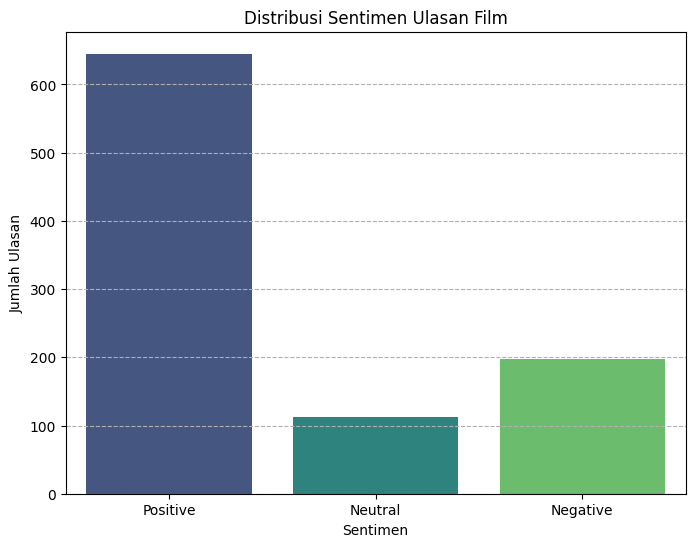


Bar chart distribusi sentimen ditampilkan.


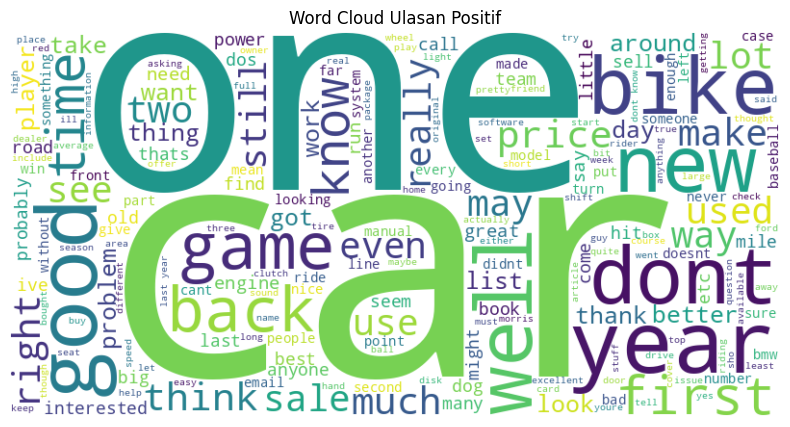

Word Cloud ulasan positif ditampilkan.


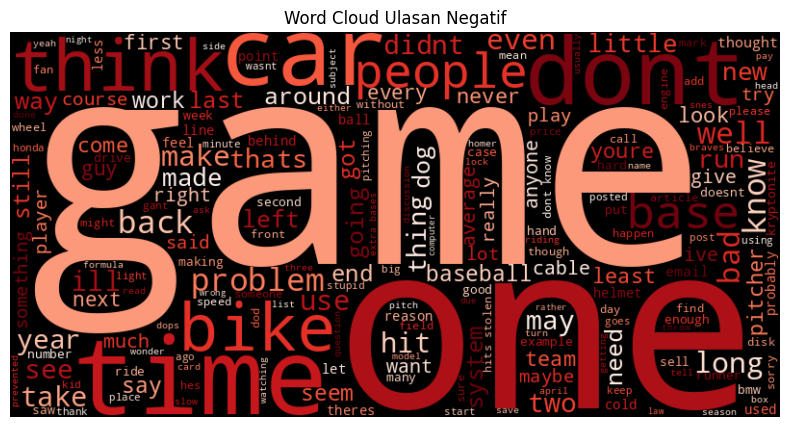

Word Cloud ulasan negatif ditampilkan.

Spark Session dihentikan.


In [10]:
# --- Langkah 5: Visualisasi Data ---
# --- Visualisasi 1: Distribusi Sentimen ---
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts_pd, palette='viridis')
plt.title('Distribusi Sentimen Ulasan Film')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.grid(axis='y', linestyle='--')
plt.show()
print("\nBar chart distribusi sentimen ditampilkan.")

# --- Visualisasi 2: Word Cloud untuk Ulasan Positif dan Negatif ---

positive_reviews_text = df_sentiments.filter(col("sentiment") == "Positive") \
                                     .select("processed_review") \
                                     .rdd.flatMap(lambda x: x) \
                                     .collect()

negative_reviews_text = df_sentiments.filter(col("sentiment") == "Negative") \
                                     .select("processed_review") \
                                     .rdd.flatMap(lambda x: x) \
                                     .collect()

positive_text_combined = " ".join(filter(None, positive_reviews_text))
negative_text_combined = " ".join(filter(None, negative_reviews_text))

if positive_text_combined:
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text_combined)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud Ulasan Positif')
    plt.show()
    print("Word Cloud ulasan positif ditampilkan.")
else:
    print("Tidak ada ulasan positif untuk membuat Word Cloud.")

if negative_text_combined:
    wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text_combined)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud Ulasan Negatif')
    plt.show()
    print("Word Cloud ulasan negatif ditampilkan.")
else:
    print("Tidak ada ulasan negatif untuk membuat Word Cloud.")

# Hentikan Spark Session
spark.stop()
print("\nSpark Session dihentikan.")

### Dampak Nyata dan Hasil Proyek

Dari proyek ini, mahasiswa dapat menunjukkan:

1.  **Data Pipelines Berfungsi:** Mereka berhasil membangun _pipeline_ dari data mentah, membersihkan, memproses, hingga siap dianalisis.
    
2.  **Analisis Sentimen Otomatis:** Sistem dapat secara otomatis mengklasifikasikan sentimen ribuan (atau jutaan dalam skala nyata) ulasan.
    
3.  **Wawasan Bisnis:**
    
    -   **Bar Chart Distribusi Sentimen:** Memberikan gambaran cepat apakah suatu film diterima secara positif atau negatif oleh publik. Misalnya, jika mayoritas ulasan negatif, ini menjadi indikasi awal masalah.
        
    -   **Word Cloud Sentimen Positif:** Menunjukkan kata kunci apa yang membuat orang menyukai film tersebut (misalnya, "aktor hebat", "cerita menawan", "efek visual"). Ini dapat membantu dalam kampanye pemasaran atau pengembangan sekuel.
        
    -   **Word Cloud Sentimen Negatif:** Menunjukkan apa yang tidak disukai penonton (misalnya, "alur lambat", "akting buruk", "akhir mengecewakan"). Informasi ini sangat berharga bagi produser untuk perbaikan di masa depan atau bagi platform streaming untuk memutuskan apakah akan merekomendasikan film tersebut.
        

Proyek ini, meskipun menggunakan dataset simulasi, secara efektif menunjukkan bagaimana seorang **Big Data Scientist** tidak hanya sekadar menguasai alat (Spark, Python), tetapi juga mampu membangun solusi _end-to-end_ yang mengubah data mentah menjadi wawasan yang dapat ditindaklanjuti dan memiliki **nilai bisnis terukur**. Ini membuktikan bahwa mahasiswa siap untuk tantangan nyata di industri.
